## MACD with Python

This is not trading advice.

MACD indicator stands for Moving Average Convergence Divergence. As the name suggests, indicator is evaluating two moving averages and the relation between them. 

Definiition of MACD from investopedia https://www.investopedia.com/terms/m/macd.asp:


$$MACD = FastEMA - SlowEMA$$

$$SignalLine = 9 period EMA from MACD$$


FastEMA = 12 period EMA from closing price   <BR>
SlowEMA = 26 period EMA from closing price   <BR>

MACD is using Exponencially weighted Moving Averages (EMA). Typical indicator setup is MACD(12,26,9) as shown above.

Bullish bias - when both lines are above zero.  <BR>
Bearish bias - when both lines are below zero.

The crossover might signify the reversal of a trend.

Buy signal is generated when MACD line crosses SignalLine from below.
Buy signal is considered to be stronger when crossover occurs below zero line. 
Buying with bearish bias expecting trend reversal.

Sell signal is generated when MACD line crosses SignalLine from above.
Sell signal is considered to be stronger when crossover occurs above zero line. 
Selling with bullish bias expecting trend reversal.

Also the further the crossover occurs from zero line, the stronger the signal.

In addition to this we have also the histogram (difference between MACD line and SignalLine) that serves as an early warning for crossovers. When bars are getting shorter, it signals that crossover signal might come soon.


We can also use MACD to spot divergences between price action and the indicator, divergences are more difficult to detect programatically though.

In [259]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [260]:
# ___variables___
ticker = 'AAPL'
#ticker = 'TSLA'
#ticker = 'FB'
#ticker = 'MSFT'
#ticker = 'NFLX'
#ticker = 'GOOGL'
#ticker = 'BIDU'
#ticker = 'AMZN'


start_time = datetime.datetime(2018, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [261]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date       High        Low       Open      Close       Volume  Adj Close
0 2018-01-02  43.075001  42.314999  42.540001  43.064999  102223600.0  41.513580
1 2018-01-03  43.637501  42.990002  43.132500  43.057499  118071600.0  41.506344
2 2018-01-04  43.367500  43.020000  43.134998  43.257500   89738400.0  41.699139
3 2018-01-05  43.842499  43.262501  43.360001  43.750000   94640000.0  42.173893
4 2018-01-08  43.902500  43.482498  43.587502  43.587502   82271200.0  42.017254


In [262]:
df = ticker_df

In [263]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Adj Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [264]:
df = computeMACD(df, 12, 26, 9)

In [265]:
print(df.head())
print(df.tail())

        Date       High        Low       Open      Close       Volume  Adj Close  MACD  MACDsig  MACDhist
0 2018-01-02  43.075001  42.314999  42.540001  43.064999  102223600.0  41.513580   NaN      NaN       NaN
1 2018-01-03  43.637501  42.990002  43.132500  43.057499  118071600.0  41.506344   NaN      NaN       NaN
2 2018-01-04  43.367500  43.020000  43.134998  43.257500   89738400.0  41.699139   NaN      NaN       NaN
3 2018-01-05  43.842499  43.262501  43.360001  43.750000   94640000.0  42.173893   NaN      NaN       NaN
4 2018-01-08  43.902500  43.482498  43.587502  43.587502   82271200.0  42.017254   NaN      NaN       NaN
          Date        High         Low        Open       Close       Volume   Adj Close      MACD   MACDsig  MACDhist
699 2020-10-12  125.180000  119.279999  120.059998  124.400002  240226800.0  124.400002  0.994992  0.076049  0.918943
700 2020-10-13  125.389999  119.650002  125.269997  121.099998  262330500.0  121.099998  1.315820  0.324003  0.991817
701 2020-1

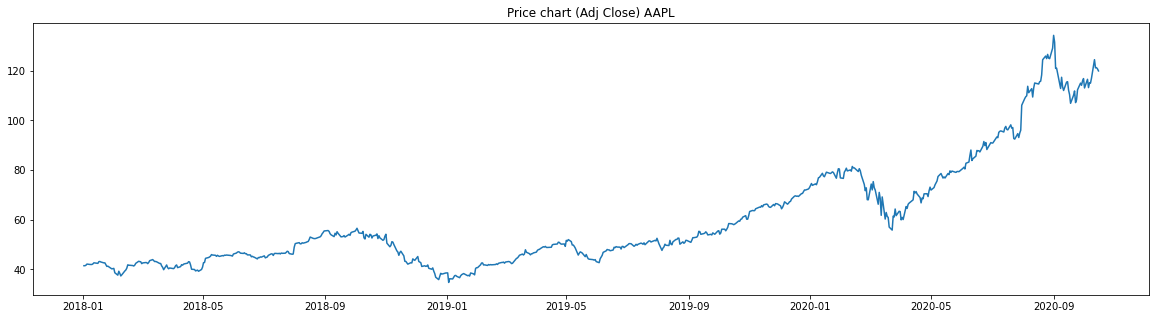

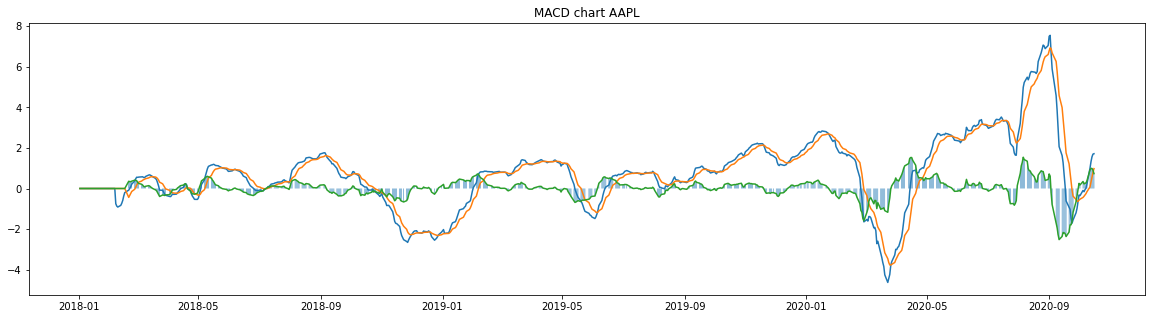

In [266]:
# plot price
plt.figure(figsize=(20,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(20,5))
plt.title('MACD chart ' + str(ticker))
plt.plot(df['Date'], df['MACD'].fillna(0))
plt.plot(df['Date'], df['MACDsig'].fillna(0))
plt.plot(df['Date'], df['MACDhist'].fillna(0))
plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)

plt.show()

In [267]:
#signalling algorithm modified from
#https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience

def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        if df['MACD'][i] > df['MACDsig'][i]:         # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                 # so first flip above means buy
            if flag != 1:                            # after first occurence I record flip to ignore
                buy_list.append(df['Close'][i])      # from here onwards
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['MACD'][i] < df['MACDsig'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(df)
df['buy_sig'] = signal[0]
df['sell_sig'] = signal[1]

In [268]:
df

,Date,High,Low,Open,Close,Volume,Adj Close,MACD,MACDsig,MACDhist,buy_sig,sell_sig
0,2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.513580,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.506344,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.699139,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,42.173893,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,42.017254,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
699,2020-10-12,125.180000,119.279999,120.059998,124.400002,240226800.0,124.400002,0.994992,0.076049,0.918943,NaN,NaN
700,2020-10-13,125.389999,119.650002,125.269997,121.099998,262330500.0,121.099998,1.315820,0.324003,0.991817,NaN,NaN
701,2020-10-14,123.029999,119.620003,121.000000,121.190002,151062300.0,121.190002,1.559365,0.571076,0.988289,NaN,NaN
702,2020-10-15,121.199997,118.150002,118.720001,120.709999,112224600.0,120.709999,1.694115,0.795684,0.898432,NaN,NaN


In [269]:
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['High'], label='High', alpha=0.2)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    plt.scatter(df['Date'], df['buy_sig'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()
       
    plt.figure(figsize=(20,5))
    plt.title('MACD chart ' + str(ticker))
    plt.plot(df['Date'], df['MACD'].fillna(0))
    plt.plot(df['Date'], df['MACDsig'].fillna(0))
    plt.plot(df['Date'], df['MACDhist'].fillna(0))
    plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)
    
    return None

#### Standard  signals
Below are shown standard MACD signals - buy when MACD line crosses above signal line and sell signals when MACD crosses below signal line.

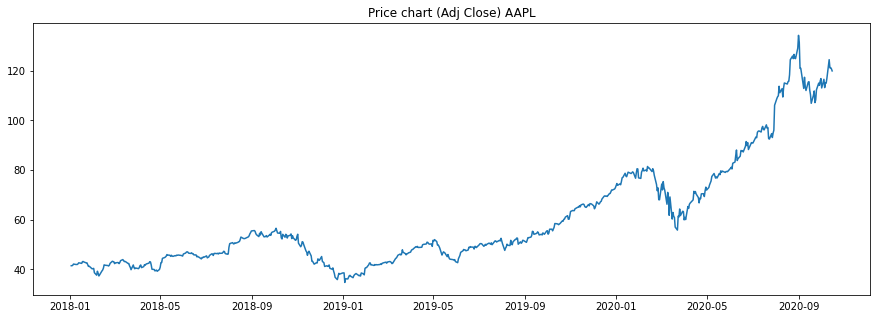

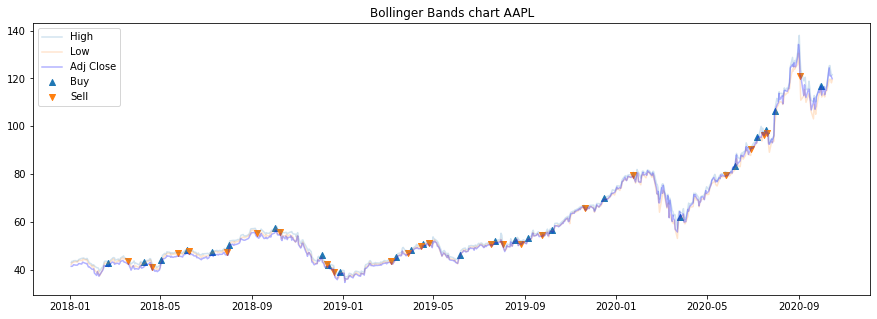

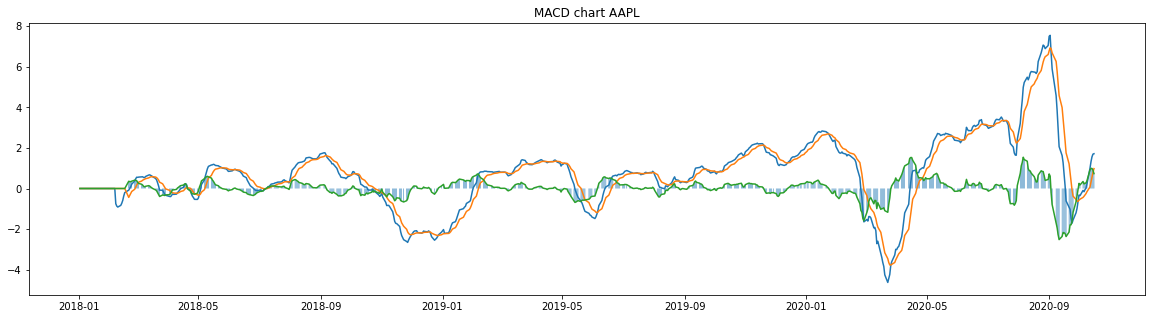

In [270]:
plot_signals(df, ticker)

#### Modified buy/sell signalling - long only below zero line, short only above zero line

when MACD line crosses above signal line - we consider it as a buy signal. But we will impose further conditions.
We will buy only when bulish MACD crossover occurs below zero line.


Further EXPERIMENTAL conditions: 

Going long when we are in short term bullish uptrend - price is above short term EMA.
Observation, if EMA is 9 or higher, we might lose important signals, so we shorten EMA to like 5 or 7. We might also experiment with extra override for crossovers that are too high and too low above/below zero line.


Sell setup is analogical.



In [271]:
def get_EMA(df, n=7):
    # computes 200 EMA
    ema = df['Adj Close'].ewm(span=n, adjust=False).mean()
    ema_200 = df['Adj Close'].ewm(span=200, adjust=False).mean()
    
    df['EMA'] = ema
    df['EMA_200'] = ema_200
    
    return df

In [272]:
df = get_EMA(df, 7)

In [273]:
#modified strategy according to tradingrush
#https://www.youtube.com/watch?v=nmffSjdZbWQ&ab_channel=TRADINGRUSH
#Not sure if using EMA is that beneficial, if so, use like 5-7 days only for short term trend

def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        # BUY
        if (df['MACD'][i] > df['MACDsig'][i]):      # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                # so first flip above means buy
            if (flag != 1) :                        # after first occurence i record flip to ignore
                                                    # from here onwards
                flag = 1
                
                # looking for higher magnitudes 
                if (   (df['High'][i] > df['EMA'][i])        and   \
                    #(df['MACD'][i] < (-2) )                        and   \
                    (df['MACD'][i] < 0)   ):
                    buy_list.append(df['Close'][i])
                #elif (df['MACD'][i] < (-3) ):   #override
                #    buy_list.append(df['Close'][i])
                
                else:
                    buy_list.append(np.nan) 
                
            else:
                buy_list.append(np.nan)
        
        # SELL
        elif (df['MACD'][i] < df['MACDsig'][i]):
            
            buy_list.append(np.nan)
            if (flag != 0) :
                flag = 0
                
                # looking for higher magnitudes
                if ( (df['Low'][i] < df['EMA'][i])     and    \
                    #(df['MACD'][i] > 2)                          and    \
                    (df['MACD'][i] > 0)   ) :
                    sell_list.append(df['Close'][i])
                #elif (df['MACD'][i] > 3 ):   #override
                #    sell_list.append(df['Close'][i])    
                else:
                    sell_list.append(np.nan)    
                
            else:
                sell_list.append(np.nan)
        
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(df)
df['buy_sig'] = signal[0]
df['sell_sig'] = signal[1]


In [274]:
def plot_signals_aligned(df, ticker):
    
    import matplotlib.gridspec as gridspec
    
    gs =  gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(30,30))   
       
       
    # __first plot__
    ax1 = fig.add_subplot(gs[0])

    ax1.plot(df['Date'], df['Adj Close'], label='Adj Close')
    ax1.set_title('Price chart (Adj Close) ' + str(ticker))
    ax1.legend()

    
    # __second plot__
    # plot  values and significant levels
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.set_title('Bollinger Bands chart ' + str(ticker))
    ax2.plot(df['Date'], df['High'], label='High', alpha=0.2)
    ax2.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    ax2.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    ax2.plot(df['Date'], df['EMA'], label='EMA', color='grey', alpha=0.3)
    ax2.plot(df['Date'], df['EMA_200'], label='EMA_200', color='grey', alpha=0.3)
    
    ax2.scatter(df['Date'], df['buy_sig'], label='Buy', marker='^', s=80)
    ax2.scatter(df['Date'], df['sell_sig'], label='Sell', marker='v', s=80)

    ax2.legend()
    
    # __third plot__
    ax3 = fig.add_subplot(gs[2], sharex=ax2)

    ax3.set_title('MACD chart ' + str(ticker))
    ax3.plot(df['Date'], df['MACD'].fillna(0), label='MACD')
    ax3.plot(df['Date'], df['MACDsig'].fillna(0), label='MACDsig')
    ax3.plot(df['Date'], df['MACDhist'].fillna(0), label='MACDhist')
    ax3.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False, label='MACDhist')
    ax3.legend()
    
    plt.show()
    
    return None

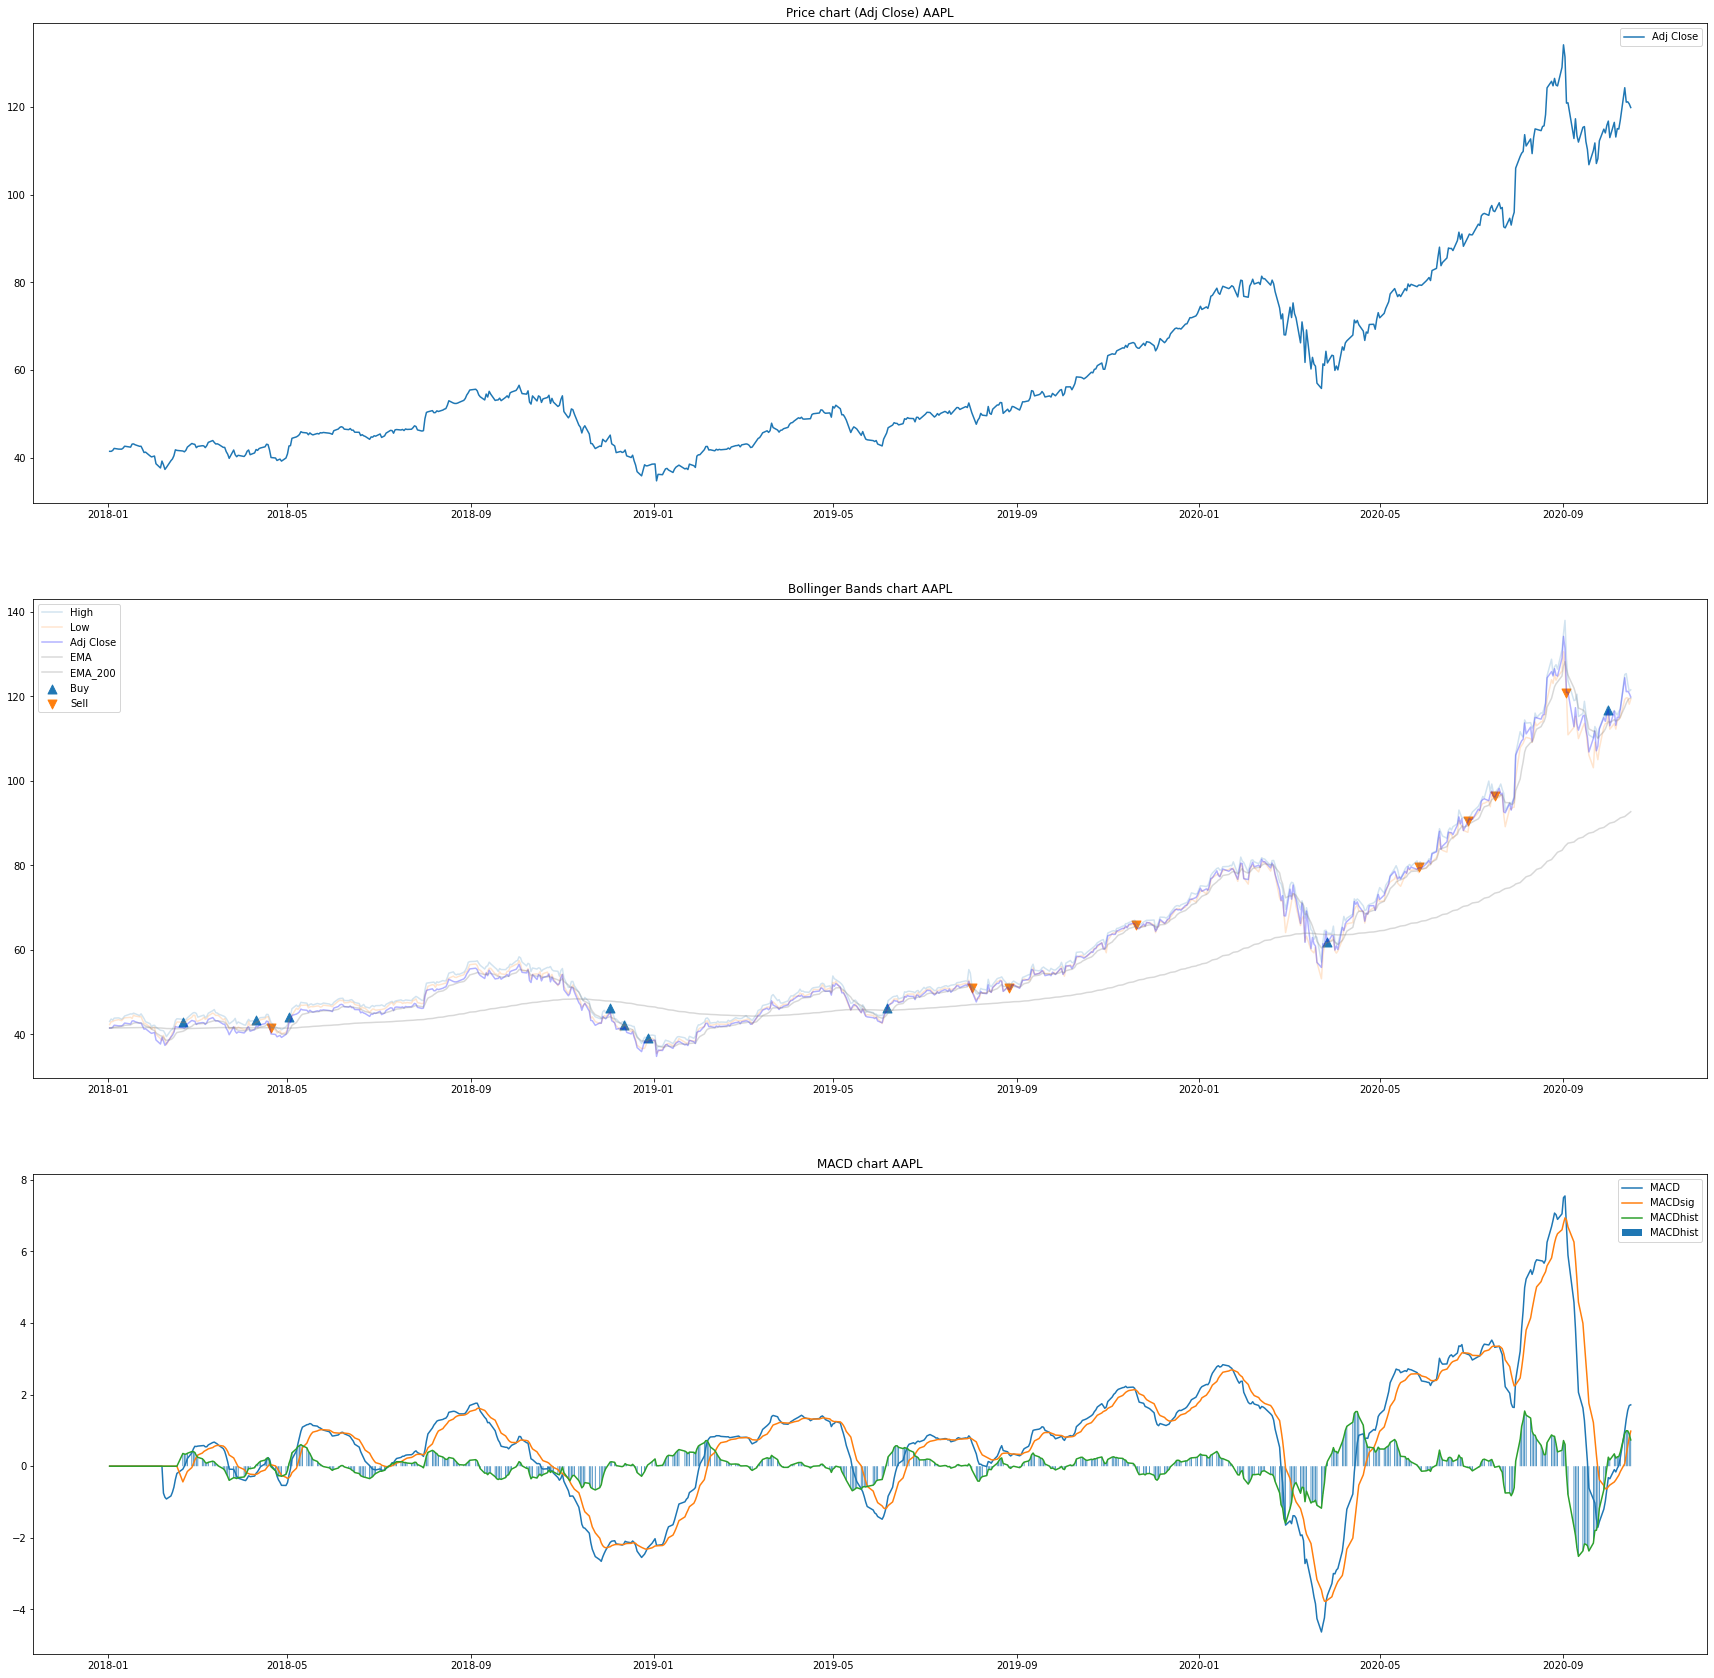

In [275]:
plot_signals_aligned(df, ticker)

By imposing further conditions we are getting less (and looks like more reliable) signals that might work well for long term investing/swing trading. 

#### Sources:
https://github.com/Crypto-toolbox/pandas-technical-indicators  <BR>
https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code  <BR>
https://www.investopedia.com/terms/m/macd.asp  <BR>    
https://www.youtube.com/watch?v=qyU9IM3M_Kw&ab_channel=EXFINSISExpertFinancialAnalysis   <BR> 
https://www.youtube.com/watch?v=E3KP1WyLITY&ab_channel=Trading212    <BR>
https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience  <BR>
    
    
https://www.youtube.com/watch?v=RzGIdibpo8Q&ab_channel=TRADINGRUSH    <BR>
https://www.youtube.com/watch?v=nmffSjdZbWQ&ab_channel=TRADINGRUSH    <BR>    

https://stackoverflow.com/questions/31810461/python-matplotlib-vertically-aligned-plots-in-matplotlib    <BR>
    
https://www.investopedia.com/terms/m/macd.asp                             <BR>
https://www.youtube.com/watch?v=n72tM2HLv34&ab_channel=TheSecretMindset   <BR>